In [1]:
from scipy.stats import linregress as LR
from ipywidgets import interact
import ipywidgets as widgets
from dataclasses import dataclass
from typing import Union, Tuple, Dict, List
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [2]:
@dataclass
class HugoniotEOS:
    name: str
    rho0: float
    C0: float
    S: float
    def hugoniot_eos(self, up: Union[float, npt.ArrayLike]) -> Union[float, npt.ArrayLike] :
        '''
        Calculate Us from linear Us-Up relationship
        '''
        Us = self.C0 + self.S*up
        return Us

    def hugoniot_P(self, up:Union[float, npt.ArrayLike])->Union[float, npt.ArrayLike]:
        '''
        Calculate pressure by using linear Us-Up relationship to get Us from Up input. 
        '''
        Us = self.hugoniot_eos(up)
        P = self.rho0*Us*up
        return P
    def solve_up(self, P: Union[npt.ArrayLike, float]) -> Union[npt.ArrayLike, float]:
        '''
        Get the Up for a given pressure or range of pressures. By solving a quadratic equation
        and taking the positive root. 
        '''
        a = self.S
        b = self.C0
        c = -P/self.rho0

        Up = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)
        return Up
@dataclass
class MixedHugoniotEOS(HugoniotEOS):
    components: List[str]
    vfracs: List[float]
    
def convert_volfrac_to_massfrac(rho1: Union[float, npt.ArrayLike], rho2: Union[float, npt.ArrayLike], Vx1: float) -> Union[float, npt.ArrayLike]:
    '''
    Converts volume frac to mass frac. 
    Expects Vx1 to be between 0 and 1
    will return the mass fraction for a given volume fraction of 
    the material with rho1. 
    '''
    mass_1 = rho1 * Vx1
    mass_2 = rho2 * (1-Vx1)
    x1 = mass_1/(mass_1 + mass_2)
    return x1
    
def generate_mixed_hugoniot_many(name:str,material_list: List[Tuple[HugoniotEOS, float]], Up: npt.ArrayLike  = np.linspace(0,8, 1000)) -> MixedHugoniotEOS:
    """
    Generates a mixed Hugoniot for a given list of materials and their volume percent

    :param name: name of new mixture
    :param material_list: list of tuples containing the material and it's respective volume fraction [(mat1, vx1), (mat2, vx2)]
    :param Up: array of particle velocities to solve for. This will be applied to the first material to get a P, after which
            We will solve for Up at the first materials pressures. 
    :returns: MixedHugonitEOS
    :raises ValueError: raises if sum of volume percents is not equal to 1
    """
    v_fracs_sum = sum(item[1] for item in material_list)
    if not np.isclose(v_fracs_sum, 1.0): # Use np.isclose for float comparison
        raise ValueError(f"Volume fractions must sum to 1, but sum to {v_fracs_sum}")
        
    mat1, xv1 = material_list[0]
    P = mat1.hugoniot_P(Up)
    
    Up_list = [Up]
    masses = [mat1.rho0 * xv1]
    vols = [masses[0]/mat1.rho0]
    names = [mat1.name]
    xvs = [xv1] # Initialize with first material's volume fraction
    
    for mat, xv_current in material_list[1:]:
        names.append(mat.name)
        xvs.append(xv_current) # Add current material's volume fraction
        mass = mat.rho0 * xv_current
        vol = mass /mat.rho0
        masses.append(mass)
        vols.append(vol)
        Up_list.append(mat.solve_up(P))
        
    rho_mix = sum(masses)/sum(vols)
    mass_frac = [m/sum(masses) for m in masses]
    
    # Ensure all Up arrays in Up_list have the same shape for consistent calculation
    # This might require interpolation if P vs Up curves are very different,
    # but for now, we assume solve_up(P) returns arrays compatible with the initial Up.
    # The sum part of mixed_Up calculation:
    sum_up_squared_times_mass_frac = np.zeros_like(Up_list[0], dtype=float)
    for up_item, mf_item in zip(Up_list, mass_frac):
        sum_up_squared_times_mass_frac += up_item**2 * mf_item
        
    mixed_Up = np.sqrt(sum_up_squared_times_mass_frac)
    
    # Avoid division by zero if mixed_Up contains zeros, especially at the start
    # We also need to ensure P and mixed_Up are sliced consistently for mixed_Us calculation
    valid_indices = mixed_Up != 0
    if not np.any(valid_indices): # If all mixed_Up are zero
        # This case should be handled based on physical expectations.
        # For now, returning an EOS with S=0 or raising an error might be options.
        # Or, if P is also all zero, Us might be undefined or C0.
        # Let's assume C0 for this scenario, implying S=0 for the mixture at low Up.
        # This is a simplification and might need refinement.
        print("Warning: All mixed_Up values are zero. Resulting mixed Us-Up slope (S) will be zero.")
        mixed_Us = np.full_like(mixed_Up, 0) # Placeholder, effectively S=0
        # regression might fail or give S=0, C0=0 if all Us are 0.
        # If P is non-zero and mixed_Up is zero, this indicates an issue.
        # For P=0, Us is C0. If mixed_Up[0] is 0, P[0] should also be 0.
        # Let's use C0 of the first component as a rough C0_mix if regression is problematic.
        C0_mix = mat1.C0 
        S_mix = 0.0
    else:
        # Slice P and mixed_Up using valid_indices to avoid division by zero
        # and to ensure arrays are of the same length for regression.
        # However, LR needs more than one point.
        # A common practice is to remove the P=0, Up=0 point for Us-Up fit.
        # Let's use indices from the second point onwards, assuming Up[0]=0.
        if len(mixed_Up[1:]) > 1 and len(P[1:]) > 1 : # Ensure enough points for regression
            mixed_Us_calc = (P[1:])/(rho_mix*mixed_Up[1:])
            regression = LR(mixed_Up[1:], mixed_Us_calc)
            C0_mix = regression.intercept
            S_mix = regression.slope
        else: # Not enough points for regression
            print("Warning: Not enough data points for Us-Up linear regression. Using C0 of first component and S=0 for mixture.")
            C0_mix = mat1.C0 # Fallback
            S_mix = 0.0      # Fallback

    mixed = MixedHugoniotEOS(name, rho_mix, C0_mix, S_mix, names, xvs)
    mixed.mfracs = mass_frac
    return mixed
            
        

def generate_mixed_hugoniot(name:str, material1: HugoniotEOS, material2: HugoniotEOS, Vx_mat1:float, Up: npt.ArrayLike = np.linspace(0,8, 1000)) -> MixedHugoniotEOS:
    """
    Generates a mixed Hugoniot for a given list of materials and their volume percent

    :param name: name of 
    :param param2: this is a second param
    :returns: this is a description of what is returned
    :raises keyError: raises an exception
    """
    P = material1.hugoniot_P(Up) 
    material1Up = Up
    material2Up = material2.solve_up(P)

    mass_mat1 = material1.rho0 * Vx_mat1
    mass_mat2 = material2.rho0 * (1-Vx_mat1)
    x_mat1 = convert_volfrac_to_massfrac(material1.rho0, material2.rho0, Vx_mat1)
    rho_mix = (mass_mat1 + mass_mat2)/((mass_mat1/material1.rho0) + (mass_mat2/material2.rho0))
    mixed_Up = np.sqrt(material1Up**2 * x_mat1 + material2Up**2 * (1-x_mat1))
    # avoid divide by zero warning, shortens result array by 1
    mixed_Us = (P[1:])/(rho_mix*mixed_Up[1:])
    regression = LR(mixed_Up[1:], mixed_Us) # match sizes of arrays by skipping first item in Up
    names = [material1.name, material2.name]
    vols = [Vx_mat1, 1-Vx_mat1]
    mfracs = [x_mat1, 1-x_mat1]
    mixed = MixedHugoniotEOS(name, rho_mix, regression.intercept, regression.slope, names, vols)
    mixed.mfracs = mfracs
    return mixed

def plot_mixture(material1: HugoniotEOS, material2: HugoniotEOS, volpercent:float) -> MixedHugoniotEOS:
    up1 = np.linspace(0.,6,1000)
    mat_list = [(material1, volpercent), (material2, 1-volpercent)]
    mix = generate_mixed_hugoniot(f'vol{str(volpercent)+material1.name + material2.name}', material1, material2, volpercent, up1)
    P = material1.hugoniot_P(up1)
    upmix = mix.solve_up(P)
    up2 = material2.solve_up(P)
    
    fig,ax = plt.subplots(1,2, figsize=(16,8))
    plt.rcParams.update({'font.size': 22})
    ax[0].plot(up1,P,'-b',linewidth=3,label=material1.name)
    ax[0].plot(material2.solve_up(P),P,'-r',linewidth=3,label=material2.name)
    ax[0].plot(mix.solve_up(P),P,'--m',linewidth=3,label=f'{mix.vfracs[0]*100:.1f} %v {material1.name}')
    ax[0].set_xlabel('up (km/s)') 
    ax[0].set_ylabel('P (GPa)')
    ax[0].legend(fontsize=14)

    ax[1].set_xlabel("Up")
    ax[1].set_ylabel("Us")
    ax[1].plot(up1, mix.hugoniot_eos(up1), label = f'{mix.vfracs[0]*100:.1f} %v {material1.name}')
    ax[1].plot(up1, material1.hugoniot_eos(up1), label  = material1.name)
    ax[1].plot(up1, material2.hugoniot_eos(up1), label = material2.name)
    ax[1].legend()
    return mix

**************************************************
Mixture parameters
 Density: 2.1532
 C0: 3.399913690979308
 S: 1.4765534738273691
Weight percent MgO: 0.6656139699052575
The mixed hugoniot data is defined in this notebook as the variable "mix"


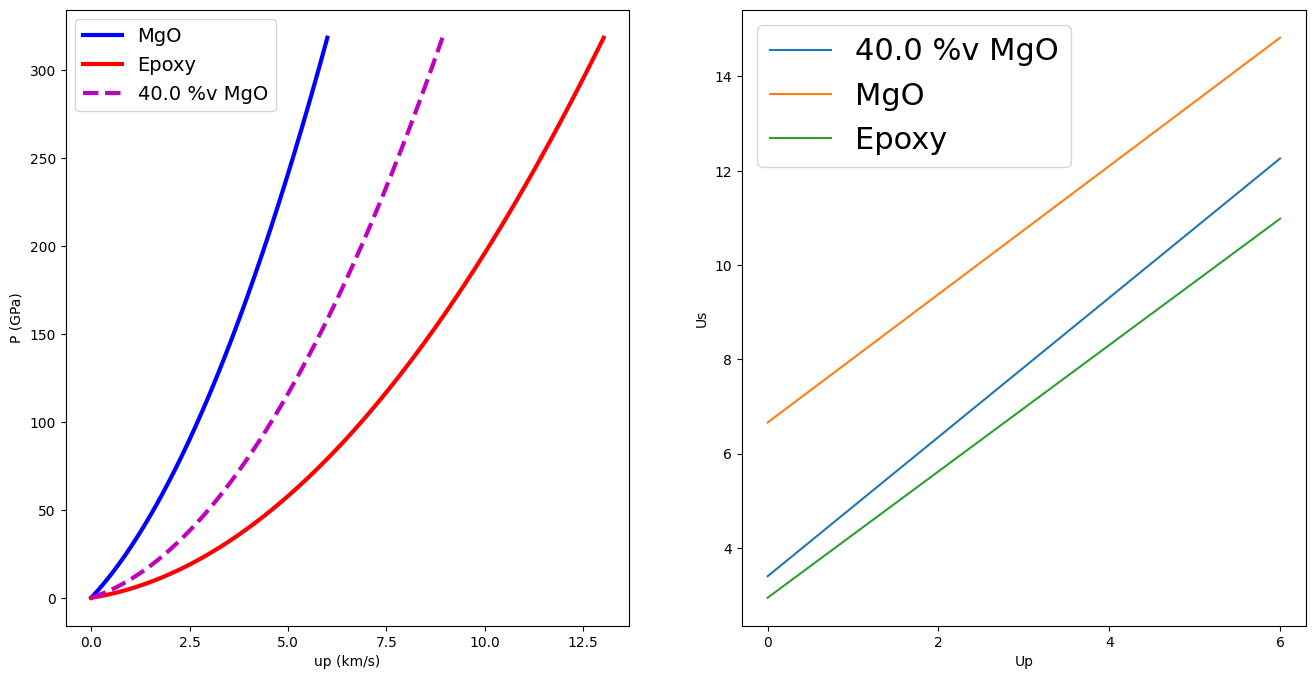

Output()

In [3]:
# Create interactive widgets for material 1
from ipywidgets.widgets import VBox, HBox
import pprint
from time import sleep
title1 = widgets.HTML('<h1>Material 1</h1>')
name1 = widgets.Text(value="MgO", description="Name")
rho0_1 = widgets.FloatText(value=3.583, description="Density")
C0_1 = widgets.FloatText(value=6.661, description="C0")
S_1 = widgets.FloatText(value=1.36, description="S")
material1_box = VBox([title1, name1, rho0_1, C0_1, S_1])

# Create interactive widgets for material 2
title2 = widgets.HTML('<h1>Material 2</h1>')
name2 = widgets.Text(value="Epoxy", description="Name")
rho0_2 = widgets.FloatText(value=1.2, description="Density")
C0_2 = widgets.FloatText(value=2.9443, descripton="C0")
S_2 = widgets.FloatText(value=1.3395, description="S")
material2_box = VBox([title2, name2, rho0_2, C0_2, S_2])

# Create widget for volume percentage
volpercent = widgets.FloatSlider(value=0.4, min=0.0, max=1.0, step=0.01, description='Mat1 v1/v')
# Combine all widgets into a single layout
ui = HBox([material1_box, material2_box, ])
ui = VBox([ui, volpercent])
def update_plot(name1, rho0_1, C0_1, S_1, name2, rho0_2, C0_2, S_2, volpercent):
    material1 = HugoniotEOS(name=name1, rho0=rho0_1, C0=C0_1, S=S_1)
    material2 = HugoniotEOS(name=name2, rho0=rho0_2, C0=C0_2, S=S_2)
    mix =  plot_mixture(material1, material2, volpercent)
    print("*"*50)
    print(f'Mixture parameters\n Density: {mix.rho0}\n C0: {mix.C0}\n S: {mix.S}')
    print(f'Weight percent {material1.name}: {mix.mfracs[0]}')
    print('The mixed hugoniot data is defined in this notebook as the variable "mix"')
out = widgets.interactive_output(update_plot, {'name1': name1, 'rho0_1': rho0_1, 'C0_1': C0_1, 'S_1': S_1, 'name2': name2, 'rho0_2': rho0_2, 'C0_2': C0_2, 'S_2': S_2, 'volpercent': volpercent})


display(ui, out)

In [4]:
def plot_mixture(material1: HugoniotEOS, material2: HugoniotEOS, volpercent:float) -> MixedHugoniotEOS:
    up1 = np.linspace(0.,6,1000)
    mat_list = [(material1, volpercent), (material2, 1-volpercent)]
    mix = generate_mixed_hugoniot_many(f'vol{str(volpercent)+material1.name + material2.name}', mat_list, up1)
    P = material1.hugoniot_P(up1)
    upmix = mix.solve_up(P)
    up2 = material2.solve_up(P)
    
    fig,ax = plt.subplots(1,2, figsize=(16,8))
    plt.rcParams.update({'font.size': 22})
    ax[0].plot(up1,P,'-b',linewidth=3,label=material1.name)
    ax[0].plot(material2.solve_up(P),P,'-r',linewidth=3,label=material2.name)
    ax[0].plot(mix.solve_up(P),P,'--m',linewidth=3,label=f'{mix.vfracs[0]*100:.1f} %v {material1.name}')
    ax[0].set_xlabel('up (km/s)') 
    ax[0].set_ylabel('P (GPa)')
    ax[0].legend(fontsize=14)

    ax[1].set_xlabel("Up")
    ax[1].set_ylabel("Us")
    ax[1].plot(up1, mix.hugoniot_eos(up1), label = f'{mix.vfracs[0]*100:.1f} %v {material1.name}')
    ax[1].plot(up1, material1.hugoniot_eos(up1), label  = material1.name)
    ax[1].plot(up1, material2.hugoniot_eos(up1), label = material2.name)
    ax[1].legend()
    return mix
def plot_mixture_many(original_materials: List[HugoniotEOS], mixed_eos: MixedHugoniotEOS, P_range_for_solve: npt.ArrayLike) -> None:
    """
    Plots the P-Up and Us-Up Hugoniots for the original materials and the calculated mixed EOS.

    :param original_materials: A list of the original HugoniotEOS objects used for the mixture.
    :param mixed_eos: The MixedHugoniotEOS object representing the mixture.
    :param P_range_for_solve: The pressure range (typically derived from the Up range of the first component)
                              used to solve for Up values for plotting consistency.
    """
    fig, ax = plt.subplots(1, 2, figsize=(18, 7))
    plt.rcParams.update({'font.size': 18})

    ax[0].set_xlabel('Up (km/s)')
    ax[0].set_ylabel('P (GPa)')
    ax[0].set_title('Pressure vs. Particle Velocity')

    base_up_for_P_plot = np.linspace(0., 8., 200) # Define a base Up range for consistent P generation
    # Generate P from the first original material to define a common P scale
    # This P_common will be used to solve for Up for all components for plotting P-Up
    P_common = original_materials[0].hugoniot_P(base_up_for_P_plot) if original_materials else np.linspace(0,100,200)

    for i, mat_orig in enumerate(original_materials):
        up_orig_solved = mat_orig.solve_up(P_common)
        ax[0].plot(up_orig_solved, P_common, lw=2.5, label=f"{mat_orig.name} (orig)")

    up_mixed_solved = mixed_eos.solve_up(P_common)
    # Construct a meaningful label for the mixed EOS
    mix_label_parts = [f"{mixed_eos.name} ({mixed_eos.rho0:.3f} g/cc, C0={mixed_eos.C0:.3f}, S={mixed_eos.S:.3f})"]
    for comp_name, vfrac in zip(mixed_eos.components, mixed_eos.vfracs):
        mix_label_parts.append(f"{vfrac*100:.1f}% {comp_name}")
    ax[0].plot(up_mixed_solved, P_common, '--', lw=3, label=", ".join(mix_label_parts))
    ax[0].legend(fontsize=10)
    ax[0].grid(True)

    ax[1].set_xlabel('Up (km/s)')
    ax[1].set_ylabel('Us (km/s)')
    ax[1].set_title('Shock Velocity vs. Particle Velocity')
    
    us_up_plot_range = np.linspace(0, np.max(base_up_for_P_plot) * 0.85 if np.any(base_up_for_P_plot) else 6, 100)

    for mat_orig in original_materials:
        ax[1].plot(us_up_plot_range, mat_orig.hugoniot_eos(us_up_plot_range), lw=2.5, label=f"{mat_orig.name} (orig)")

    ax[1].plot(us_up_plot_range, mixed_eos.hugoniot_eos(us_up_plot_range), '--', lw=3, label=f"{mixed_eos.name} (mix)")
    ax[1].legend(fontsize=10)
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# --- New UI for Multiple Materials ---
from ipywidgets import VBox, HBox, IntText, FloatText, Text, Button, Output, HTML, Layout
import numpy as np # Ensure numpy is imported here if not globally available in this cell context

# Global list to store material widget sets
material_widget_sets = []

# Output widget for errors or messages
status_output = Output()

# Container for dynamic material input fields
dynamic_material_inputs_container = VBox([])

num_materials_input = IntText(value=2, description='Num Materials:', min=1, max=10)
up_min_input = FloatText(value=0.0, description='Up min (km/s):')
up_max_input = FloatText(value=8.0, description='Up max (km/s):')
num_points_input = IntText(value=1000, description='Num Points (Up):')
mix_name_input = Text(value="MyMixture", description="Mixture Name:")


def create_material_widgets(num_materials):
    global material_widget_sets
    material_widget_sets = [] # Clear previous widgets
    new_widgets_list = []
    for i in range(num_materials):
        title = HTML(f'<h3>Material {i+1}</h3>')
        name_widget = Text(value=f"Mat{i+1}", description='Name:')
        rho0_widget = FloatText(value=1.0, description='Density (g/cc):')
        c0_widget = FloatText(value=1.5, description='C0 (km/s):')
        s_widget = FloatText(value=1.5, description='S:')
        vfrac_widget = FloatText(value=round(1.0/num_materials, 3) if num_materials > 0 else 0, description='Vol. Frac.:', step=0.01)
        
        material_box = VBox([title, name_widget, rho0_widget, c0_widget, s_widget, vfrac_widget])
        material_widget_sets.append({
            'name': name_widget, 'rho0': rho0_widget, 'C0': c0_widget, 'S': s_widget, 'vfrac': vfrac_widget
        })
        new_widgets_list.append(material_box)
    dynamic_material_inputs_container.children = tuple(new_widgets_list)

# Initial creation for default number of materials
create_material_widgets(num_materials_input.value)

# Update widget list when num_materials_input changes
num_materials_input.observe(lambda change: create_material_widgets(change.new), names='value')

calculate_button = Button(description="Calculate & Plot Mixture")
plot_output_area = Output()

def on_calculate_button_clicked(b):
    with plot_output_area:
        plot_output_area.clear_output(wait=True)
        status_output.clear_output()
        try:
            material_list_for_function = []
            original_eos_list = []
            current_vfrac_sum = 0
            for i,m_set in enumerate(material_widget_sets):
                name = m_set['name'].value
                rho0 = m_set['rho0'].value
                C0 = m_set['C0'].value
                S_val = m_set['S'].value
                vfrac = m_set['vfrac'].value
                current_vfrac_sum += vfrac
                
                if not name or rho0 <= 0 or C0 <=0: # Basic validation
                    with status_output:
                        print(f"Error: Invalid input for Material {i+1}. Name must be non-empty, rho0 and C0 > 0.")
                    return
                
                eos = HugoniotEOS(name, rho0, C0, S_val)
                original_eos_list.append(eos)
                material_list_for_function.append((eos, vfrac))
            
            if not np.isclose(current_vfrac_sum, 1.0):
                with status_output:
                    print(f"Warning: Volume fractions sum to {current_vfrac_sum:.3f}, not 1.0. Results may be indicative but not strictly physical based on input fractions.")
                    # Optionally, you could normalize here or prevent calculation.

            if not material_list_for_function:
                with status_output:
                    print("Error: No materials defined for calculation.")
                return

            up_array = np.linspace(up_min_input.value, up_max_input.value, num_points_input.value)
            if not np.any(up_array): # Handle case where up_array might be empty or all zero due to inputs
                with status_output:
                    print("Error: Particle velocity (Up) array is empty or invalid. Check Up min/max/points.")
                return

            mixture_name = mix_name_input.value if mix_name_input.value else "UnnamedMixture"
            mixed_eos_result = generate_mixed_hugoniot_many(mixture_name, material_list_for_function, Up=up_array)
            
            # For P_range_for_solve in plot_mixture_many, use the P from the first component's Up array
            P_plot_range = material_list_for_function[0][0].hugoniot_P(up_array)
            plot_mixture_many(original_eos_list, mixed_eos_result, P_plot_range)
            
            # Print mixture parameters
            print("\n" + "*"*50)
            print(f'Calculated Mixture: {mixed_eos_result.name}')
            print(f'  Density (rho0_mix): {mixed_eos_result.rho0:.4f} g/cc')
            print(f'  C0_mix: {mixed_eos_result.C0:.4f} km/s')
            print(f'  S_mix: {mixed_eos_result.S:.4f}')
            print("  Component Volume Fractions:")
            for comp_name, vfrac in zip(mixed_eos_result.components, mixed_eos_result.vfracs):
                print(f"    {comp_name}: {vfrac*100:.2f}%")
            if hasattr(mixed_eos_result, 'mfracs'):
                print("  Component Mass Fractions:")
                for comp_name, mfrac in zip(mixed_eos_result.components, mixed_eos_result.mfracs):
                    print(f"    {comp_name}: {mfrac*100:.2f}%")
            print("*"*50)

        except ValueError as ve:
            with status_output:
                print(f"Input Error: {ve}")
        except Exception as e:
            with status_output:
                import traceback
                print(f"An unexpected error occurred: {e}")
                # print(traceback.format_exc()) # For more detailed debugging if needed

calculate_button.on_click(on_calculate_button_clicked)

# Layout the UI
settings_box = VBox([
    HBox([num_materials_input, mix_name_input]),
    HBox([up_min_input, up_max_input, num_points_input])
])

ui_multi_material = VBox([settings_box, dynamic_material_inputs_container, calculate_button, status_output, plot_output_area])

display(ui_multi_material)